<a href="https://colab.research.google.com/github/JFrankVC/tog/blob/main/RNN_DailyData_Prediction_AOD_MLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0. Import Libraries

In [1]:
# Mount the Google Drive
# Allow access - check steps and methods in: https://neptune.ai/blog/google-colab-dealing-with-files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # if Colab root directory is shown, go to /content folder

Mounted at /content/drive


In [2]:
# How to install permanently non-preinstalled libraries
!pip install earthpy && touch /root/.ipython/profile_default/startup/00-first.py && echo "import earthpy" >> /root/.ipython/profile_default/startup/00-first.py

In [3]:
!pip install pyhdf && touch /root/.ipython/profile_default/startup/00-first.py && echo "import pyhdf" >> /root/.ipython/profile_default/startup/00-first.py

In [4]:
# Import packages
import os
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import numpy.ma as ma
import xarray as xr
from shapely.geometry import mapping, box
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import pandas as pd
from sklearn import preprocessing
from tensorflow import keras
from tensorflow.keras import layers
import statsmodels.api as sm

# Import package pyhdf for reading HDF files (method used in local code)
from pyhdf.SD import SD, SDC
import numpy as np

from osgeo import gdal
xr.set_options(display_style='html')

### 1. Prepare Dataset

In [5]:
# Check current working directory corresponds to Google Drive
retval = os.getcwd()
print(f"Current working directory {retval}")

# Change the directory - Google Drive
path = "/content/drive/MyDrive/Colab_Notebooks/Datasets/MODIS_Proyecto_PAD/GIOVANNI/Time_Series/Daily/"
os.chdir(path)

# Check current working directory corresponds to Google Drive
retval = os.getcwd()
print(f"Current working directory {retval}")

Current working directory /content
Current working directory /content/drive/MyDrive/Colab_Notebooks/Datasets/MODIS_Proyecto_PAD/GIOVANNI/Time_Series/Daily


In [6]:
# Set path to Dataset folder
folder_path = "/content/drive/MyDrive/Colab_Notebooks/Datasets/MODIS_Proyecto_PAD/GIOVANNI/Time_Series/Daily/"

In [7]:
# List all daily datasets in current folder
!ls

g4.areaAvgTimeSeries.AIRS3STD_7_0_SurfSkinTemp_A.20080101-20221231.180W_90S_180E_90N.csv
g4.areaAvgTimeSeries.AIRS3STD_7_0_SurfSkinTemp_D.20080101-20221231.180W_90S_180E_90N.csv
g4.areaAvgTimeSeries.MOD08_D3_6_1_Deep_Blue_Aerosol_Optical_Depth_550_Land_Mean.20080101-20221231.180W_90S_180E_90N.csv
g4.areaAvgTimeSeries.MOD08_D3_6_1_Deep_Blue_Angstrom_Exponent_Land_Mean.20080101-20221231.180W_90S_180E_90N.csv


In [8]:
# Read datasets in folder
series = [f for f in os.listdir()]

# Read Angstrom/Temp/
for df_i in range(len(series)):

    if 'Angstrom' in series[df_i]:
        angstrom_t = pd.read_csv(series[df_i], parse_dates=[0], index_col=0, skiprows=7)
        angstrom_t.rename(columns=lambda x: x.strip(), inplace=True)
        print(angstrom_t)

    if 'Temp_A' in series[df_i]:
        temp_day_t = pd.read_csv(series[df_i], parse_dates=[0], index_col=0, skiprows=7)
        temp_day_t.rename(columns=lambda x: x.strip(), inplace=True)
        print(temp_day_t)

    if 'Temp_D' in series[df_i]:
        temp_night_t = pd.read_csv(series[df_i], parse_dates=[0], index_col=0, skiprows=7)
        temp_night_t.rename(columns=lambda x: x.strip(), inplace=True)
        print(temp_night_t)

    if 'Optical' in series[df_i]:
        aod_t = pd.read_csv(series[df_i], parse_dates=[0], index_col=0, skiprows=7)
        aod_t.rename(columns=lambda x: x.strip(), inplace=True)
        print(aod_t)

    if 'MASS' in series[df_i]:
        mass_t = pd.read_csv(series[df_i], parse_dates=[0], index_col=0, skiprows=7)
        mass_t.rename(columns=lambda x: x.strip(), inplace=True)
        print(mass_t)

            mean_MOD08_D3_6_1_Deep_Blue_Aerosol_Optical_Depth_550_Land_Mean
time                                                                       
2008-01-01                                           0.051563              
2008-01-02                                           0.041597              
2008-01-03                                           0.037373              
2008-01-04                                           0.064934              
2008-01-05                                           0.043597              
...                                                       ...              
2022-12-27                                           0.033867              
2022-12-28                                           0.049197              
2022-12-29                                           0.067794              
2022-12-30                                           0.046676              
2022-12-31                                           0.042947              

[5456 rows 

In [9]:
# Rename columns
angstrom_t.rename(
    columns={'mean_MOD08_D3_6_1_Deep_Blue_Angstrom_Exponent_Land_Mean' : 'Angstrom_Exponent'},
    inplace=True
    )

temp_day_t.rename(
    columns={'mean_AIRS3STD_7_0_SurfSkinTemp_A' : 'SurfAirTemp_Day'},
    inplace=True
    )

temp_night_t.rename(
    columns={'mean_AIRS3STD_7_0_SurfSkinTemp_D' : 'SurfAirTemp_Night'},
    inplace=True
    )

aod_t.rename(
    columns={'mean_MOD08_D3_6_1_Deep_Blue_Aerosol_Optical_Depth_550_Land_Mean' : 'Aerosol_Optical_Depth'},
    inplace=True
    )

#mass_t.rename(
    #columns={'mean_M2TMNXAER_5_12_4_TOTSMASS25' : 'PM2_5_Mass_Concentration'},
    #inplace=True
    #)

Text(0.5, 1.0, 'Correlation Map')

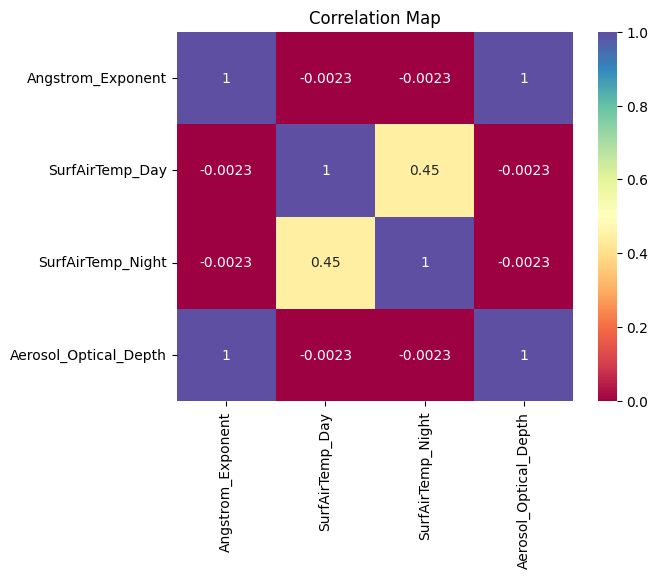

In [10]:
# Join datasets by time index
df = angstrom_t.copy()
df = df.merge(temp_day_t.copy(), on='time')
df = df.merge(temp_night_t.copy(), on='time')
df = df.merge(aod_t.copy(), on='time')

#df.drop(labels=['Mov_Avg_Angstrom_Exponent', 'Mov_Avg_SurfAirTemp', 'Mov_Avg_Aerosol_Optical_Depth', 'Mov_Avg_PM2_5_Mass_Concentration'], axis=1, inplace=True)

# Correlation Map
sns.heatmap(df.corr(), cmap='Spectral', annot=True)
plt.title('Correlation Map')

In [11]:
df.count().isna()

Angstrom_Exponent        False
SurfAirTemp_Day          False
SurfAirTemp_Night        False
Aerosol_Optical_Depth    False
dtype: bool

In [12]:
# Show dataset statisstics
df.replace(-9999.0, np.nan, inplace=True)
df.describe()

,Angstrom_Exponent,SurfAirTemp_Day,SurfAirTemp_Night,Aerosol_Optical_Depth
count,5386.000000,5394.000000,5395.000000,5386.000000
mean,1.330926,306.792724,289.459247,0.089798
std,0.146932,5.357701,3.628720,0.045121
min,0.268319,291.537476,278.684052,0.020272
25%,1.256257,302.682251,286.563583,0.056400
50%,1.370474,306.781814,289.998413,0.080101
75%,1.445489,310.809570,292.559220,0.112781
max,1.771911,320.296387,300.300629,0.630838


In [13]:
df.isna().sum()

Angstrom_Exponent        19
SurfAirTemp_Day          11
SurfAirTemp_Night        10
Aerosol_Optical_Depth    19
dtype: int64

In [14]:
df = df.dropna()

In [15]:
df.isna().sum()

Angstrom_Exponent        0
SurfAirTemp_Day          0
SurfAirTemp_Night        0
Aerosol_Optical_Depth    0
dtype: int64

<Axes: xlabel='time', ylabel='Angstrom_Exponent'>

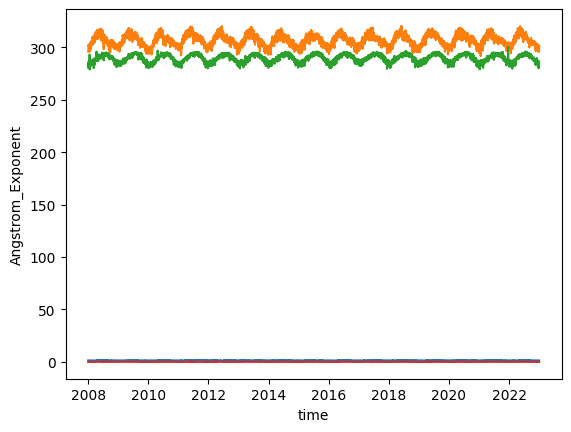

In [16]:
# Plot variables
sns.lineplot(data=df, x='time', y='Angstrom_Exponent')
sns.lineplot(data=df, x='time', y='SurfAirTemp_Day')
sns.lineplot(data=df, x='time', y='SurfAirTemp_Night')
sns.lineplot(data=df, x='time', y='Aerosol_Optical_Depth')

In [102]:
# Scaling needed
df_scaled = df.copy()
df_scaled['Angstrom_Exponent'] = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(df_scaled['Angstrom_Exponent'].values.reshape(-1,1))
df_scaled['SurfAirTemp_Day'] = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(df_scaled['SurfAirTemp_Day'].values.reshape(-1,1))
df_scaled['SurfAirTemp_Night'] = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(df_scaled['SurfAirTemp_Night'].values.reshape(-1,1))
df_scaled['Aerosol_Optical_Depth'] = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(df_scaled['Aerosol_Optical_Depth'].values.reshape(-1,1))

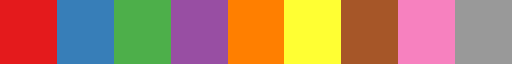

In [18]:
plt.get_cmap('Set1')

Text(0, 0.5, 'AOD')

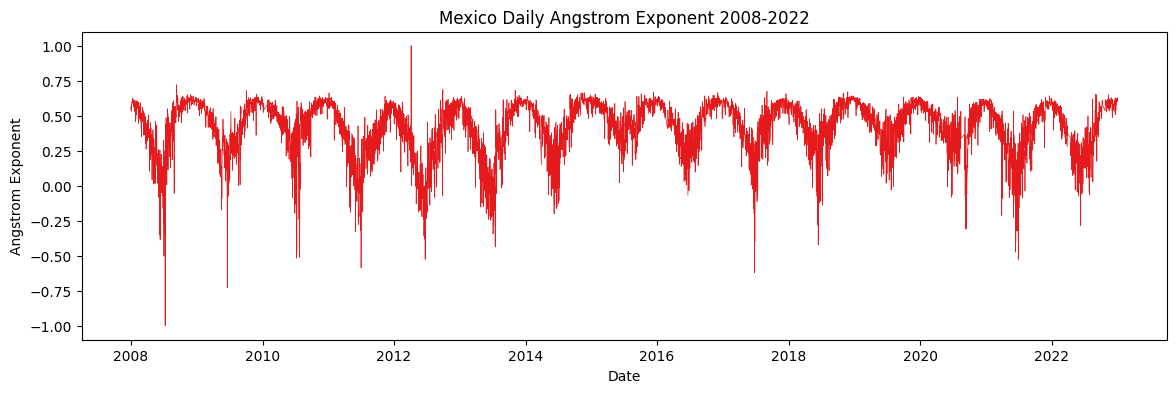

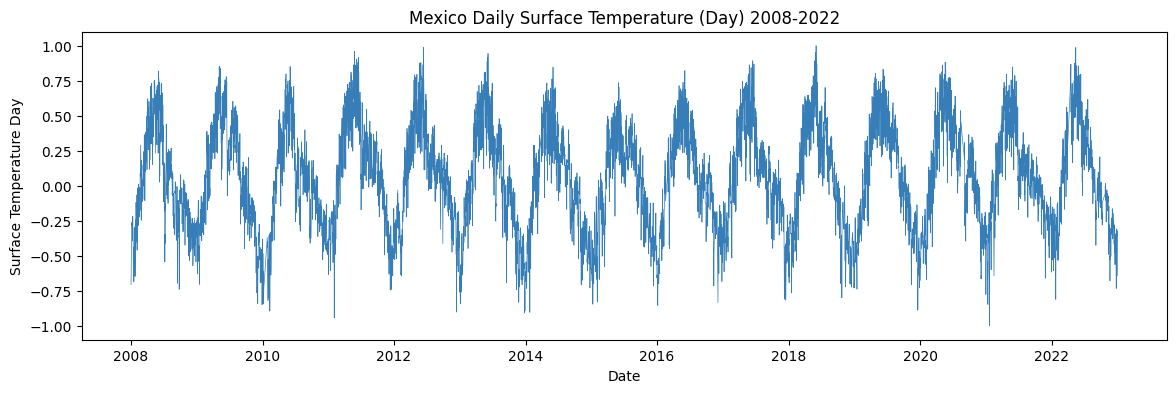

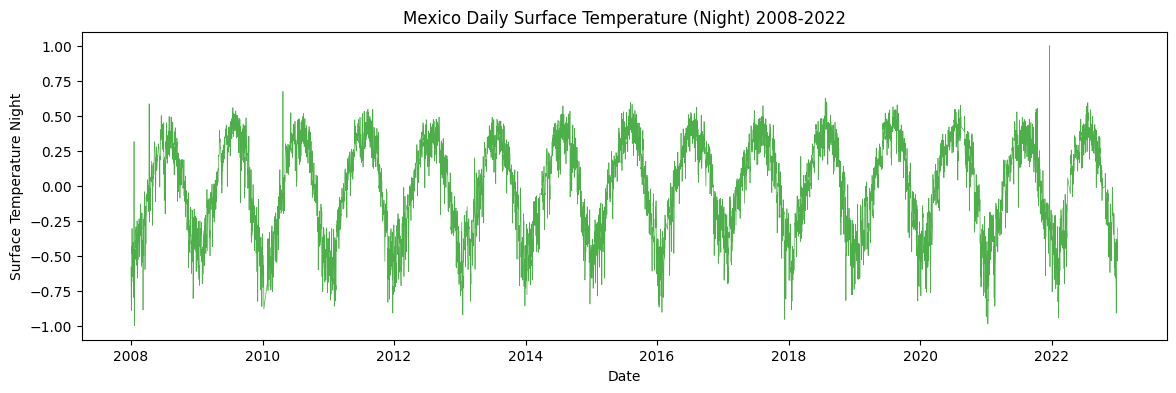

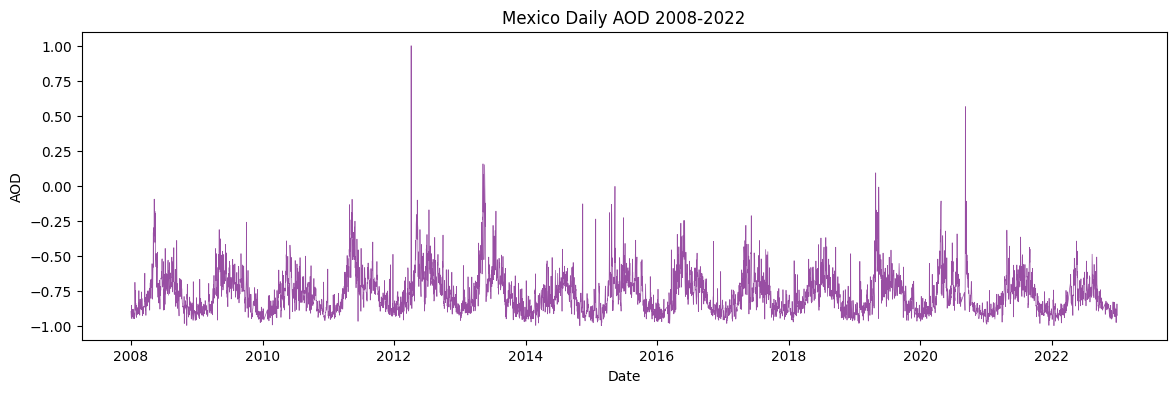

In [103]:
# Plot variables
plt.figure(figsize=(14, 4))
sns.lineplot(data=df_scaled, x='time', y='Angstrom_Exponent', color=plt.get_cmap('Set1')(0), linewidth=0.5)
plt.title('Mexico Daily Angstrom Exponent 2008-2022')
plt.xlabel('Date')
plt.ylabel('Angstrom Exponent')

plt.figure(figsize=(14, 4))
sns.lineplot(data=df_scaled, x='time', y='SurfAirTemp_Day', color=plt.get_cmap('Set1')(1), linewidth=0.5)
plt.title('Mexico Daily Surface Temperature (Day) 2008-2022')
plt.xlabel('Date')
plt.ylabel('Surface Temperature Day')

plt.figure(figsize=(14, 4))
sns.lineplot(data=df_scaled, x='time', y='SurfAirTemp_Night', color=plt.get_cmap('Set1')(2), linewidth=0.5)
plt.title('Mexico Daily Surface Temperature (Night) 2008-2022')
plt.xlabel('Date')
plt.ylabel('Surface Temperature Night')

plt.figure(figsize=(14, 4))
sns.lineplot(data=df_scaled, x='time', y='Aerosol_Optical_Depth', color=plt.get_cmap('Set1')(3), linewidth=0.5)
plt.title('Mexico Daily AOD 2008-2022')
plt.xlabel('Date')
plt.ylabel('AOD')

In [20]:
df_scaled.describe()

,Angstrom_Exponent,SurfAirTemp_Day,SurfAirTemp_Night,Aerosol_Optical_Depth
count,5370.000000,5370.000000,5370.000000,5370.000000
mean,0.751090,0.957845,0.963909,0.142428
std,0.082995,0.016725,0.012078,0.071587
min,0.151429,0.910212,0.928605,0.032135
25%,0.708966,0.945007,0.954254,0.089419
50%,0.773552,0.957808,0.965726,0.127025
75%,0.815779,0.970413,0.974241,0.178879
max,1.000000,1.000000,1.000000,1.000000


In [104]:
df_scaled.isna().sum()

Angstrom_Exponent        0
SurfAirTemp_Day          0
SurfAirTemp_Night        0
Aerosol_Optical_Depth    0
dtype: int64

#### Teme-Series plot (Scaled Data)

Text(0, 0.5, 'Measurements')

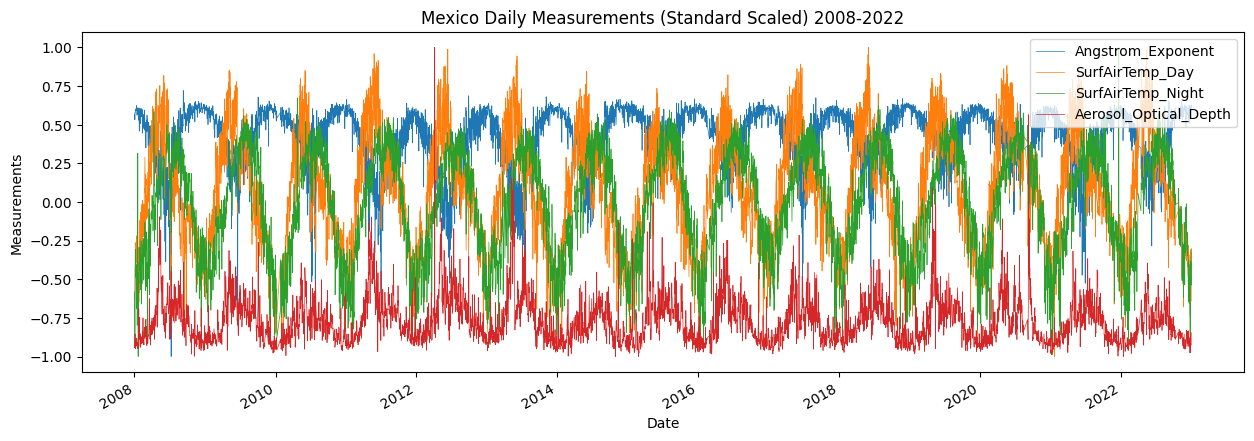

In [105]:
df_scaled.plot(figsize=(15, 5), linewidth=0.5)
plt.title('Mexico Daily Measurements (Standard Scaled) 2008-2022')
plt.xlabel('Date')
plt.ylabel('Measurements')

#### Correlation Map (Scaled Data)

Text(0.5, 1.0, 'Correlation Map')

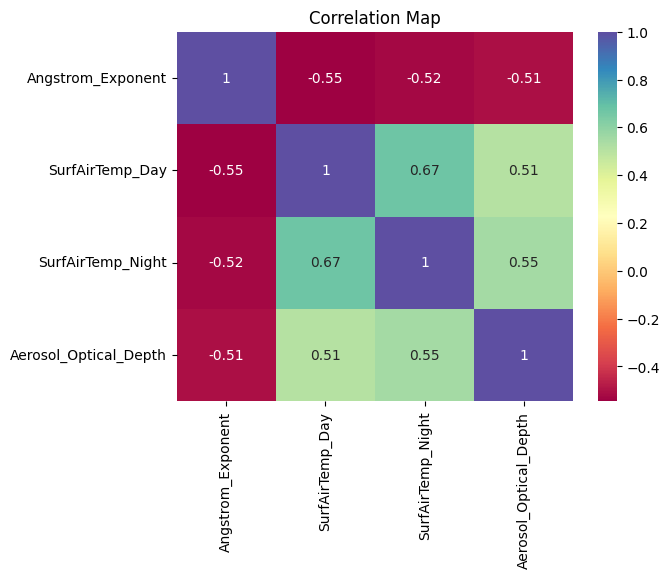

In [106]:
# Correlation Map
sns.heatmap(df_scaled.corr(), cmap='Spectral', annot=True)
plt.title('Correlation Map')

#### Boxplots

In [107]:
# Add month column for monthly analysis
df_scaled['month'] = df.index.strftime('%b')
df_scaled

,Angstrom_Exponent,SurfAirTemp_Day,SurfAirTemp_Night,Aerosol_Optical_Depth,month
time,,,,,
2008-01-01,0.542467,-0.706558,-0.580336,-0.897502,Jan
2008-01-02,0.569423,-0.649746,-0.706002,-0.930149,Jan
2008-01-03,0.532049,-0.525412,-0.890615,-0.943983,Jan
2008-01-04,0.581658,-0.389729,-0.806423,-0.853705,Jan
2008-01-05,0.580096,-0.262994,-0.435408,-0.923595,Jan
...,...,...,...,...,...
2022-12-27,0.610974,-0.446611,-0.742390,-0.955467,Dec
2022-12-28,0.608508,-0.308118,-0.381120,-0.905254,Dec
2022-12-29,0.625700,-0.642924,-0.402570,-0.844335,Dec


In [ ]:
df_scaled

Text(0, 0.5, 'AOD')

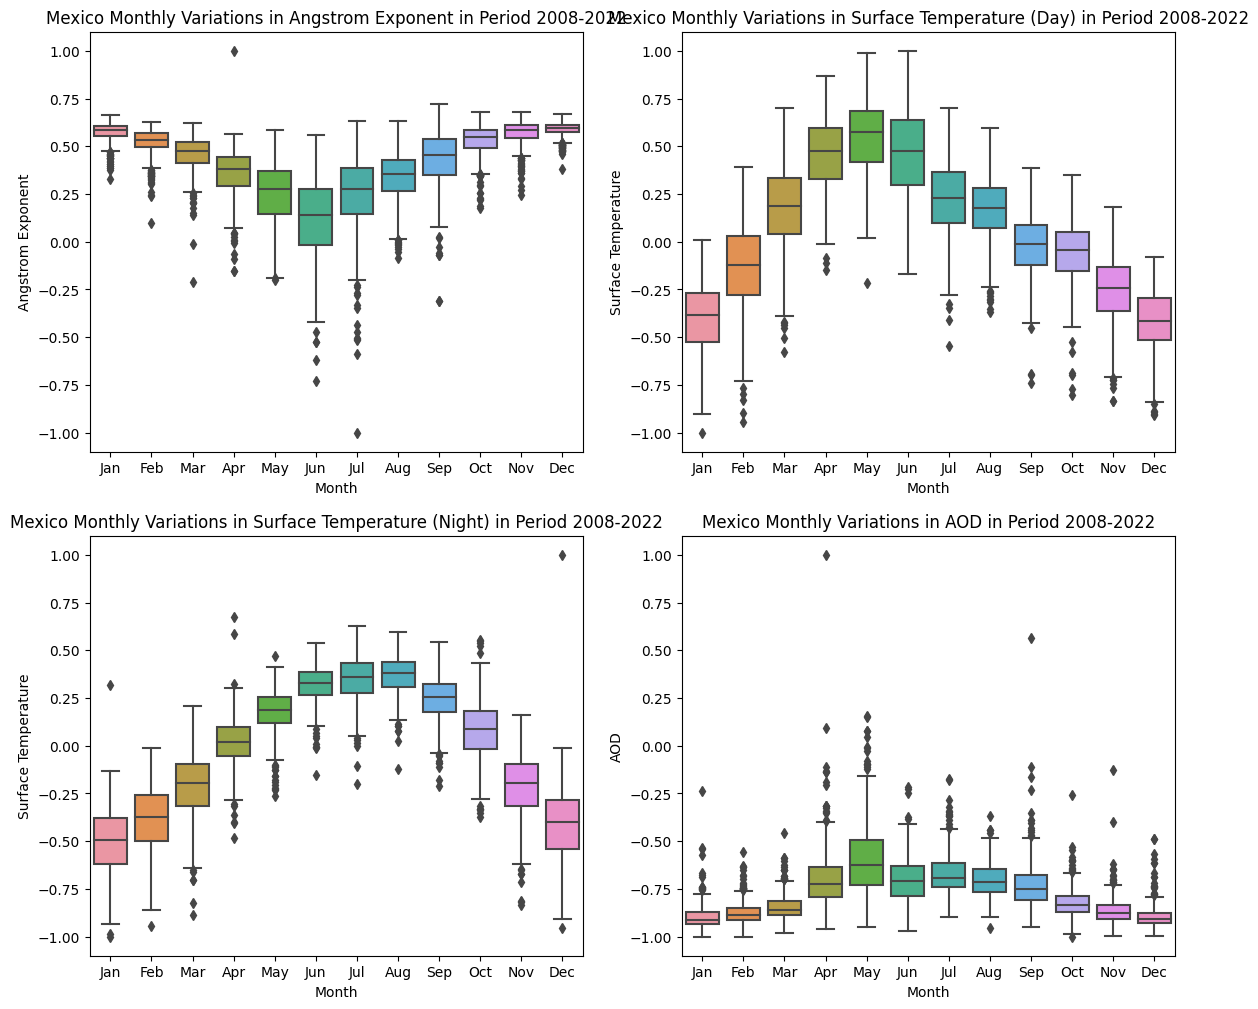

In [108]:
plt.figure(figsize=(14, 12))

plt.subplot(2, 2, 1)
sns.boxplot(x='month', y='Angstrom_Exponent', data=df_scaled)
plt.title('Mexico Monthly Variations in Angstrom Exponent in Period 2008-2022')
plt.xlabel('Month')
plt.ylabel('Angstrom Exponent')

plt.subplot(2, 2, 2)
sns.boxplot(x='month', y='SurfAirTemp_Day', data=df_scaled)
plt.title('Mexico Monthly Variations in Surface Temperature (Day) in Period 2008-2022')
plt.xlabel('Month')
plt.ylabel('Surface Temperature')

plt.subplot(2, 2, 3)
sns.boxplot(x='month', y='SurfAirTemp_Night', data=df_scaled)
plt.title('Mexico Monthly Variations in Surface Temperature (Night) in Period 2008-2022')
plt.xlabel('Month')
plt.ylabel('Surface Temperature')

plt.subplot(2, 2, 4)
sns.boxplot(x='month', y='Aerosol_Optical_Depth', data=df_scaled)
plt.title('Mexico Monthly Variations in AOD in Period 2008-2022')
plt.xlabel('Month')
plt.ylabel('AOD')

#### Split train/val/test

In [110]:
LEN_SAMPLES = df_scaled.shape[0]
n_train_samples = int(0.7 * LEN_SAMPLES)        # 70% training
n_val_samples = int(0.2 * LEN_SAMPLES)         # 20% validation
n_test_samples = LEN_SAMPLES - n_train_samples - n_val_samples   # 10% test
print("# Train Samples:", n_train_samples)
print("# Val Samples:", n_val_samples)
print("# Test Samples:", n_test_samples)

# Train Samples: 3758
# Val Samples: 1074
# Test Samples: 538


In [111]:
# To Numpy Arrays
# AOD - target (y)
aod = df_scaled['Aerosol_Optical_Depth'].values

# Other data
data = df_scaled.drop(columns=['month']).values

aod.shape, data.shape

((5370,), (5370, 4))

In [112]:
aod = np.array(aod).reshape(-1,)
data = np.array(data).reshape(-1, data.shape[-1])
aod.shape, data.shape

((5370,), (5370, 4))

In [129]:
sampling_rate = 2    # 6 sample per month
sequence_length = 30   # 30 days
delay = sampling_rate * (sequence_length + 3 - 1)   # 8 days of delay
batch_size = 128    # 128 samples per batch

train_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=aod[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=n_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=aod[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=n_train_samples,
    end_index=n_train_samples + n_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=aod[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=n_train_samples + n_val_samples,
    )

In [114]:
n_train_samples + n_val_samples

4832

In [32]:
data.shape[-1]

4

In [33]:
val_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [34]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [130]:
for samples, targets in test_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (128, 30, 4)
targets shape: (128,)


#### Create and train LSTM model

In [131]:
inputs = keras.Input(shape=(sequence_length, data.shape[-1]))
x = layers.LSTM(2048, return_sequences=True)(inputs)
x = layers.LSTM(1024, return_sequences=True)(x)
x = layers.LSTM(512, return_sequences=True)(x)
x = layers.LSTM(256, return_sequences=True)(x)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(32)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.0001), loss="mse", metrics=["mse", "mae"])
history = model.fit(train_dataset,
                    epochs=150,
                    validation_data=val_dataset)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/150
29/29 [==============================] - 70s 355ms/step - loss: 0.5982 - mse: 0.5982 - mae: 0.7598 - val_loss: 0.6040 - val_mse: 0.6040 - val_mae: 0.7639
Epoch 2/150
29/29 [==============================] - 8s 289ms/step - loss: 0.5548 - mse: 0.5548 - mae: 0.7307 - val_loss: 0.5609 - val_mse: 0.5609 - val_mae: 0.7353
Epoch 3/150
29/29 [==============================] - 8s 260ms/step - loss: 0.5145 - mse: 0.5145 - mae: 0.7027 - val_loss: 0.5211 - val_mse: 0.5211 - val_mae: 0.7078
Epoch 4/150
29/29 [==============================] - 8s 268ms/step - loss: 0.4771 - mse: 0.4771 - mae: 0.6756 - val_loss: 0.4841 - val_mse: 0.4841 - val_mae: 0.6813
Epoch 5/150
29/29 [==============================] - 8s 259ms/step - loss: 0.4427 - mse: 0.4427 - mae: 0.6497 - val_loss: 0.4498 - val_mse: 0.4498 - val_mae: 0.6558
Epoch 6/150
29/29 [==============================] - 8s 289ms/step - loss: 0.4106 - mse: 0.4106 - mae: 0.6247 - val_loss: 0.4180 - val_mse: 0.4180 - val_mae: 0.6312
Epoch 7/1

In [132]:
if len(test_dataset) == 0:
  raise ValueError("Expected input data to be non-empty - here.")

Text(0, 0.5, 'Loss')

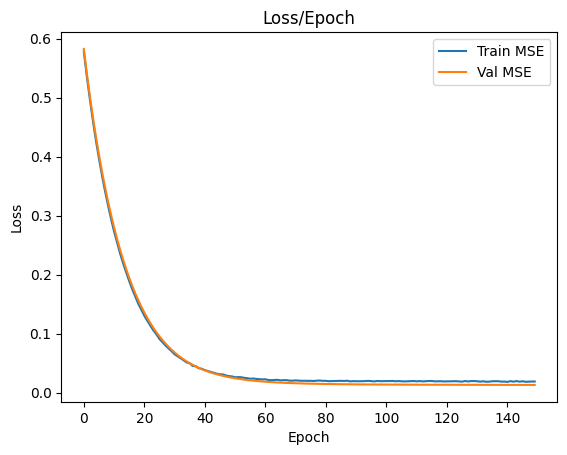

In [169]:
# Plot training and validation losses
sns.lineplot(x=history.epoch, y=history.history['mse'], label='Train MSE')
sns.lineplot(x=history.epoch, y=history.history['val_mse'], label='Val MSE')
plt.title("Loss/Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

#### Evaluate LSTM model

In [134]:
model.evaluate(test_dataset)

4/4 [==============================] - 0s 81ms/step - loss: 0.0131 - mse: 0.0131 - mae: 0.0982


[0.01310456357896328, 0.01310456357896328, 0.09821002185344696]

In [40]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

#### Compare predictions

In [135]:
TIME_LEN = aod.shape[0]
time_steps = np.array(range(TIME_LEN))
#time_steps = time_steps.reshape(-1, 1)
time_steps.shape, aod.shape


((5370,), (5370,))

In [120]:
test_ds = data[n_train_samples + n_val_samples + n_test_samples - 30 :]
test_ds.shape
test_ds.reshape((-1, test_ds.shape[-1])).shape

(30, 4)

In [43]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [136]:
aod_pred = model.predict(test_dataset)
aod_pred = aod_pred.reshape(-1,)
aod_pred.shape

4/4 [==============================] - 4s 76ms/step


(416,)

<Axes: >

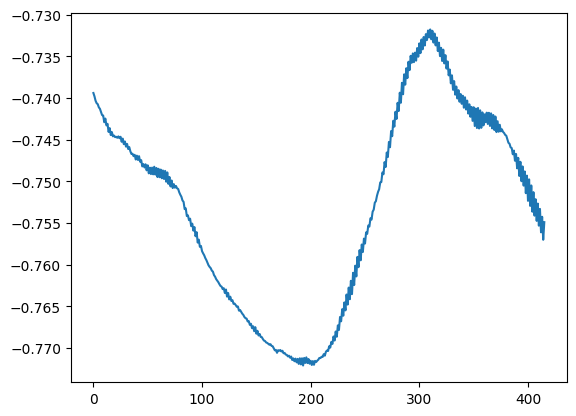

In [137]:
sns.lineplot(x=np.array(range(len(aod_pred))), y=aod_pred)

In [138]:
off_ = n_train_samples + n_val_samples + n_test_samples - len(aod_pred)
time_steps_pred = np.array(range(len(aod_pred)))
time_steps_pred = time_steps_pred + off_
time_steps_pred.shape

(416,)

Text(0, 0.5, 'AOD')

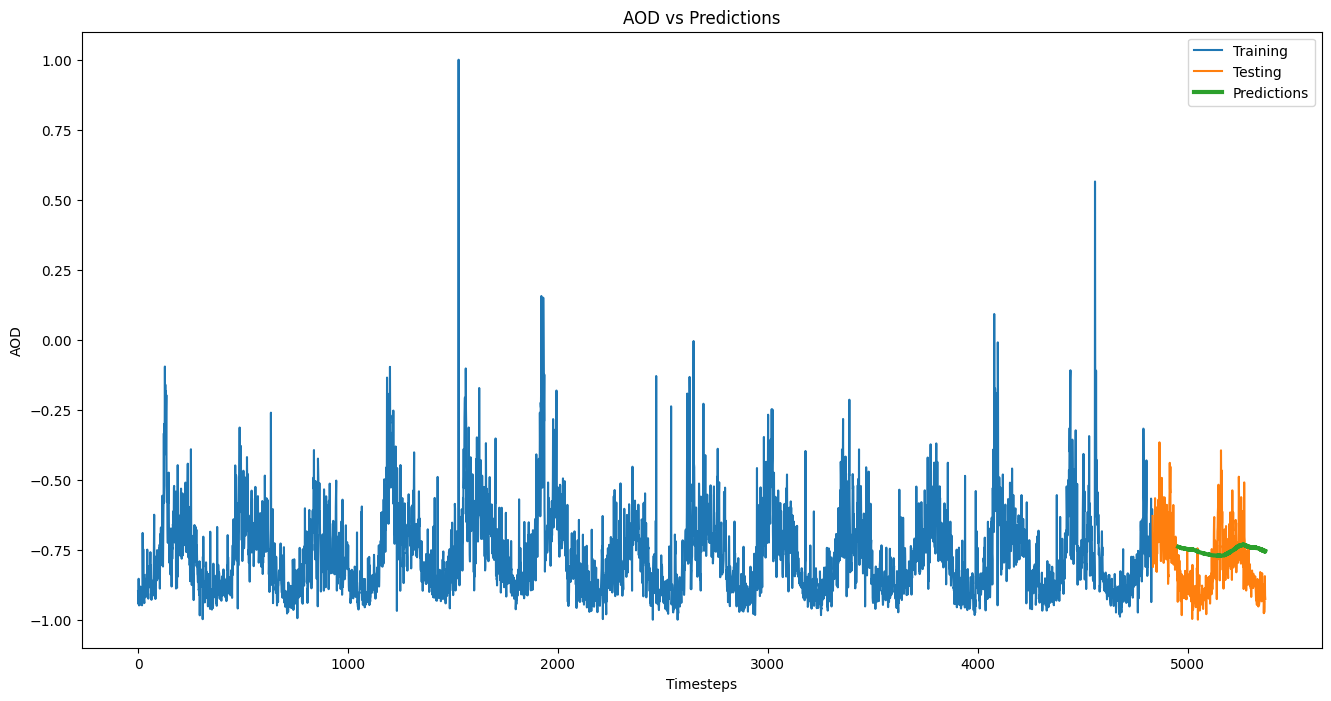

In [168]:
plt.figure(figsize=(16, 8))
sns.lineplot(x=time_steps[:n_train_samples+n_val_samples], y=aod[:n_train_samples+n_val_samples], label="Training")
sns.lineplot(x=time_steps[n_train_samples+n_val_samples:], y=aod[n_train_samples+n_val_samples:], label="Testing")
sns.lineplot(x=time_steps_pred, y=aod_pred, linewidth=3, label="Predictions")
plt.title("AOD vs Predictions")
plt.xlabel("Timesteps")
plt.ylabel("AOD")

#### Filter signals (data to observe behavior on predictions)

In [140]:
aod_filtered = aod.copy()
aod_filtered.shape

(5370,)

In [141]:
temp_d_filtered = df_scaled['SurfAirTemp_Day'].copy().to_numpy()

temp_n_filtered = df_scaled['SurfAirTemp_Night'].copy().to_numpy()

angst_filtered = df_scaled['Angstrom_Exponent'].copy().to_numpy()

temp_d_filtered.shape, temp_n_filtered.shape, angst_filtered.shape

((5370,), (5370,), (5370,))

In [142]:
# Filter features
aod_cycle, aod_trend = sm.tsa.filters.hpfilter(aod_filtered)
temp_d_cycle, temp_d_trend = sm.tsa.filters.hpfilter(temp_d_filtered)
temp_n_cycle, temp_n_trend = sm.tsa.filters.hpfilter(temp_n_filtered)
angst_cycle, angst_trend = sm.tsa.filters.hpfilter(angst_filtered)

In [143]:
aod_cycle.shape, aod_trend.shape

((5370,), (5370,))

<Axes: >

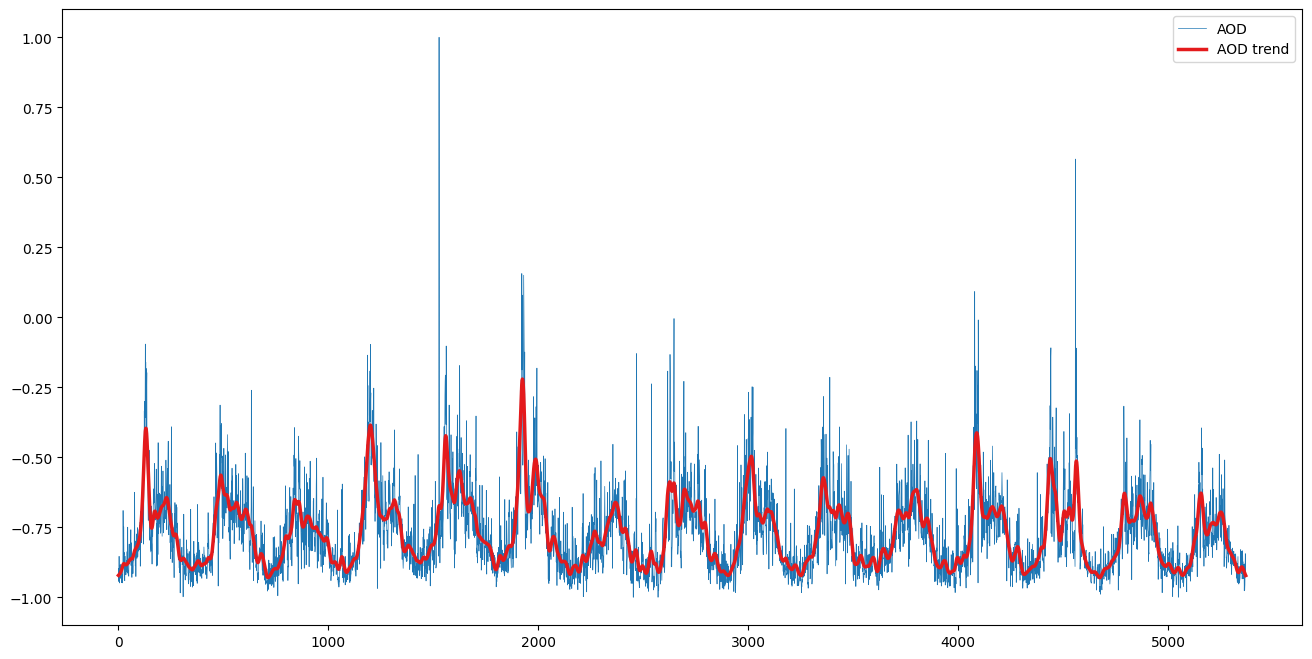

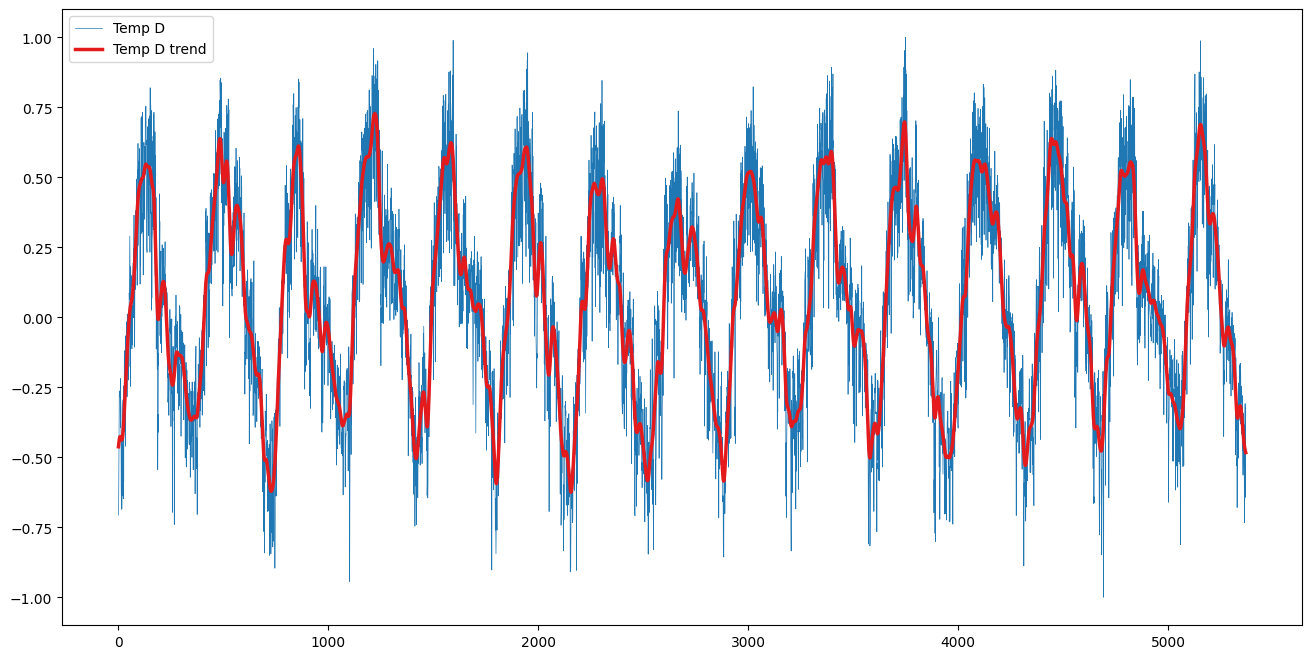

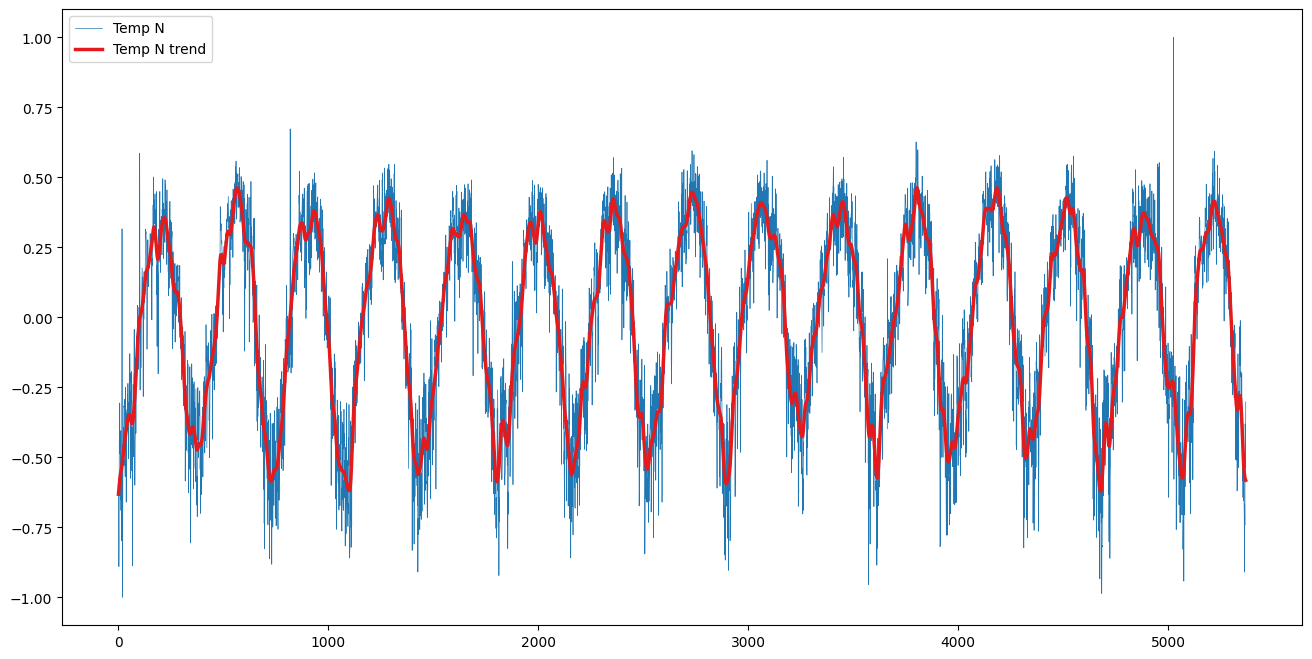

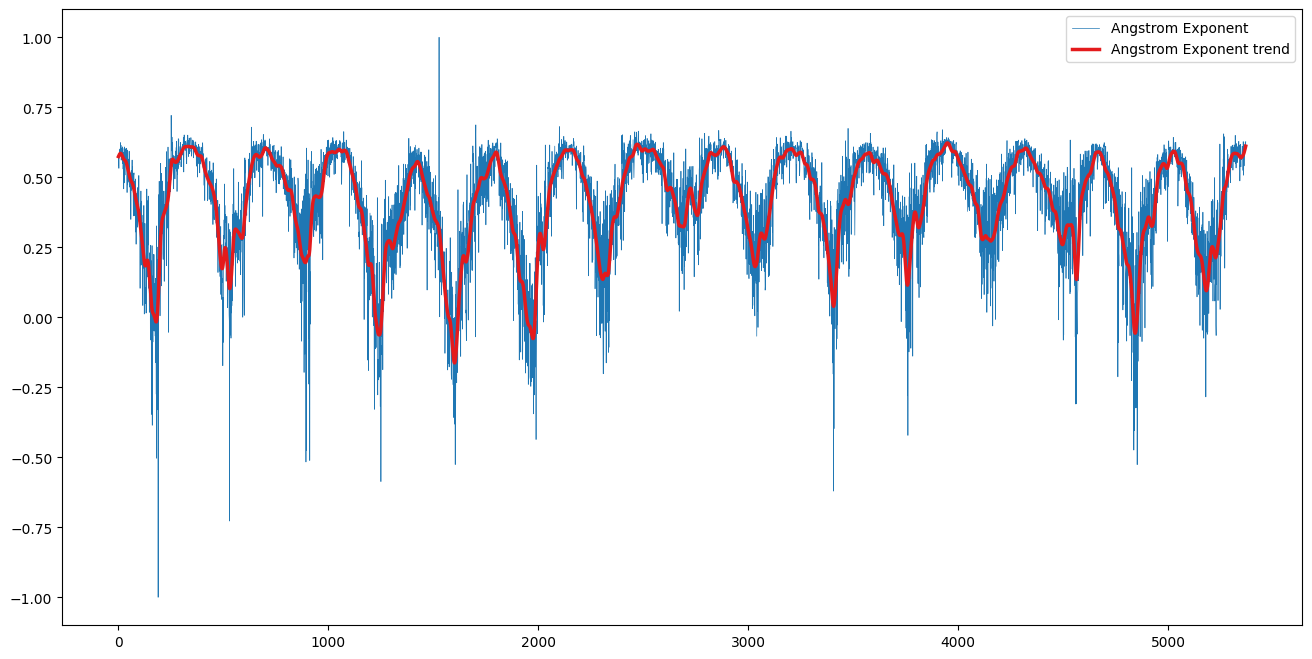

In [144]:
# Plot filtered features
plt.figure(figsize=(16, 8))
sns.lineplot(x=time_steps, y=aod, linewidth=0.5, label="AOD")
sns.lineplot(x=time_steps, y=aod_trend, linewidth=2.5, color=plt.get_cmap('Set1')(0), label="AOD trend")

plt.figure(figsize=(16, 8))
sns.lineplot(x=time_steps, y=temp_d_filtered, linewidth=0.5, label="Temp D")
sns.lineplot(x=time_steps, y=temp_d_trend, linewidth=2.5, color=plt.get_cmap('Set1')(0), label="Temp D trend")

plt.figure(figsize=(16, 8))
sns.lineplot(x=time_steps, y=temp_n_filtered, linewidth=0.5, label="Temp N")
sns.lineplot(x=time_steps, y=temp_n_trend, linewidth=2.5, color=plt.get_cmap('Set1')(0), label="Temp N trend")

plt.figure(figsize=(16, 8))
sns.lineplot(x=time_steps, y=angst_filtered, linewidth=0.5, label="Angstrom Exponent")
sns.lineplot(x=time_steps, y=angst_trend, linewidth=2.5, color=plt.get_cmap('Set1')(0), label="Angstrom Exponent trend")

In [145]:
# Get filtered arrays
aod_filtered = aod_trend
temp_d_filtered = temp_d_trend
temp_n_filtered = temp_n_trend
angst_filtered = angst_trend

In [146]:
# Get copy of scaled DF for same arrangement and set filtered values
df_filtered = df_scaled.copy()
df_filtered['Aerosol_Optical_Depth'] = aod_filtered
df_filtered['SurfAirTemp_Day'] = temp_d_filtered
df_filtered['SurfAirTemp_Night'] = temp_n_filtered
df_filtered['Angstrom_Exponent'] = angst_filtered

In [147]:
df_filtered.head()

,Angstrom_Exponent,SurfAirTemp_Day,SurfAirTemp_Night,Aerosol_Optical_Depth,month
time,,,,,
2008-01-01,0.574024,-0.462332,-0.632060,-0.921758,Jan
2008-01-02,0.575742,-0.455443,-0.623096,-0.920977,Jan
2008-01-03,0.577439,-0.448707,-0.614100,-0.920181,Jan
2008-01-04,0.579094,-0.442397,-0.605092,-0.919360,Jan
2008-01-05,0.580653,-0.436836,-0.596262,-0.918520,Jan


Text(0, 0.5, 'Measurements')

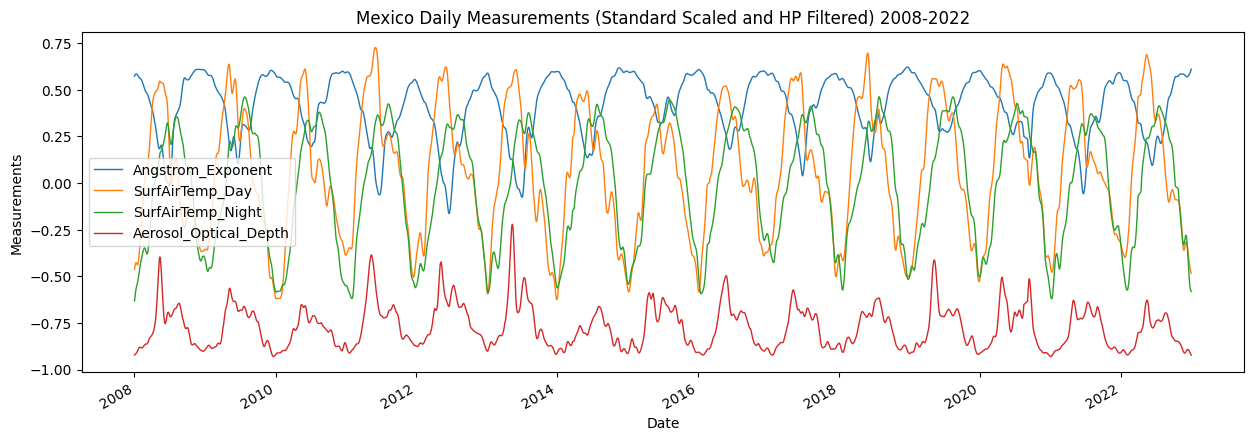

In [156]:
df_filtered.plot(figsize=(15, 5), linewidth=1)
plt.title('Mexico Daily Measurements (Standard Scaled and HP Filtered) 2008-2022')
plt.xlabel('Date')
plt.ylabel('Measurements')

<ipython-input-149-879dca334bc4>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_filtered.corr(), cmap='Spectral', annot=True)


Text(0.5, 1.0, 'Correlation Map')

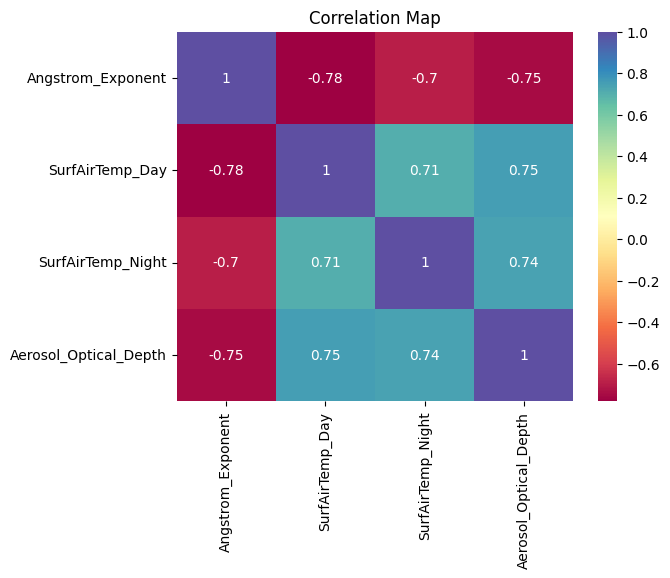

In [149]:
# Correlation Map
sns.heatmap(df_filtered.corr(), cmap='Spectral', annot=True)
plt.title('Correlation Map')

Text(0, 0.5, 'AOD')

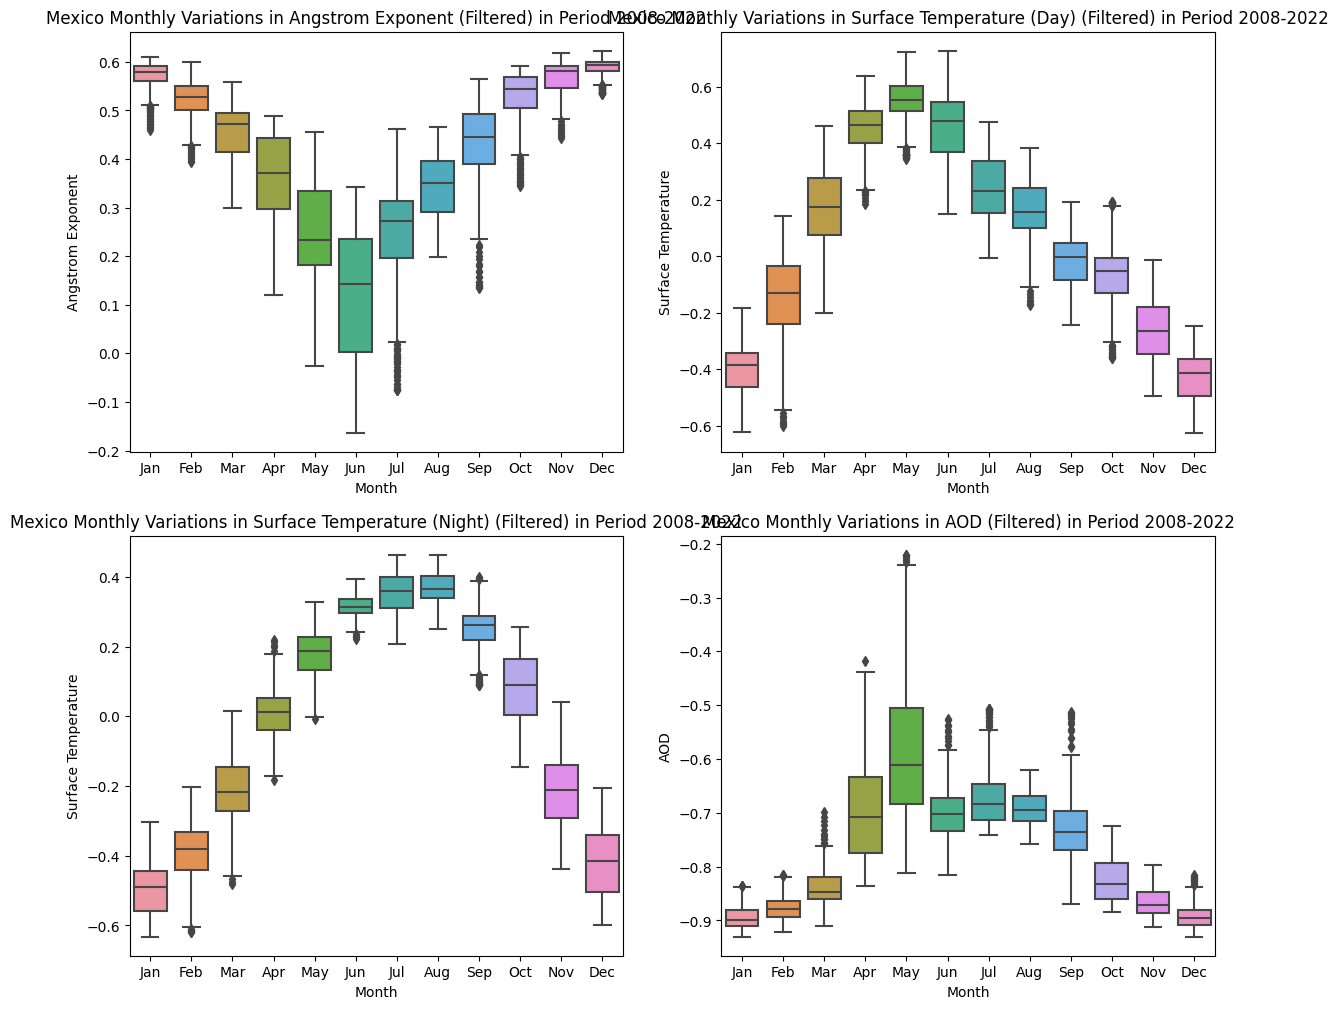

In [150]:
plt.figure(figsize=(14, 12))

plt.subplot(2, 2, 1)
sns.boxplot(x='month', y='Angstrom_Exponent', data=df_filtered)
plt.title('Mexico Monthly Variations in Angstrom Exponent (Filtered) in Period 2008-2022')
plt.xlabel('Month')
plt.ylabel('Angstrom Exponent')

plt.subplot(2, 2, 2)
sns.boxplot(x='month', y='SurfAirTemp_Day', data=df_filtered)
plt.title('Mexico Monthly Variations in Surface Temperature (Day) (Filtered) in Period 2008-2022')
plt.xlabel('Month')
plt.ylabel('Surface Temperature')

plt.subplot(2, 2, 3)
sns.boxplot(x='month', y='SurfAirTemp_Night', data=df_filtered)
plt.title('Mexico Monthly Variations in Surface Temperature (Night) (Filtered) in Period 2008-2022')
plt.xlabel('Month')
plt.ylabel('Surface Temperature')

plt.subplot(2, 2, 4)
sns.boxplot(x='month', y='Aerosol_Optical_Depth', data=df_filtered)
plt.title('Mexico Monthly Variations in AOD (Filtered) in Period 2008-2022')
plt.xlabel('Month')
plt.ylabel('AOD')

In [151]:
# To Numpy Arrays
# AOD - target (y)
aod_filt = df_filtered['Aerosol_Optical_Depth'].values

# Other data
data_filt = df_filtered.drop(columns=['month']).values

aod_filt.shape, data_filt.shape

((5370,), (5370, 4))

In [152]:
sampling_rate = 2    # 6 sample per month
sequence_length = 30   # 30 days
delay = sampling_rate * (sequence_length + 3 - 1)   # 8 days of delay
batch_size = 128    # 128 samples per batch

train_dataset_filt = keras.utils.timeseries_dataset_from_array(
    data_filt[:-delay],
    targets=aod_filt[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=n_train_samples)

val_dataset_filt = keras.utils.timeseries_dataset_from_array(
    data_filt[:-delay],
    targets=aod_filt[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=n_train_samples,
    end_index=n_train_samples + n_val_samples)

test_dataset_filt = keras.utils.timeseries_dataset_from_array(
    data_filt[:-delay],
    targets=aod_filt[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=n_train_samples + n_val_samples,
    )

In [153]:
for samples, targets in test_dataset_filt:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (128, 30, 4)
targets shape: (128,)


In [155]:
inputs = keras.Input(shape=(sequence_length, data.shape[-1]))
x = layers.LSTM(2048, return_sequences=True)(inputs)
x = layers.LSTM(1024, return_sequences=True)(x)
x = layers.LSTM(512, return_sequences=True)(x)
x = layers.LSTM(256, return_sequences=True)(x)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(32)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.0001), loss="mse", metrics=["mse", "mae"])
history = model.fit(train_dataset_filt,
                    epochs=150,
                    validation_data=val_dataset_filt)

print(f"Test MAE: {model.evaluate(test_dataset_filt)[1]:.2f}")

Epoch 1/150
29/29 [==============================] - 19s 343ms/step - loss: 0.5782 - mse: 0.5782 - mae: 0.7516 - val_loss: 0.5827 - val_mse: 0.5827 - val_mae: 0.7547
Epoch 2/150
29/29 [==============================] - 7s 256ms/step - loss: 0.5359 - mse: 0.5359 - mae: 0.7229 - val_loss: 0.5410 - val_mse: 0.5410 - val_mae: 0.7266
Epoch 3/150
29/29 [==============================] - 8s 268ms/step - loss: 0.4972 - mse: 0.4972 - mae: 0.6956 - val_loss: 0.5026 - val_mse: 0.5026 - val_mae: 0.6996
Epoch 4/150
29/29 [==============================] - 8s 263ms/step - loss: 0.4610 - mse: 0.4610 - mae: 0.6690 - val_loss: 0.4670 - val_mse: 0.4670 - val_mae: 0.6737
Epoch 5/150
29/29 [==============================] - 8s 276ms/step - loss: 0.4274 - mse: 0.4274 - mae: 0.6433 - val_loss: 0.4339 - val_mse: 0.4339 - val_mae: 0.6487
Epoch 6/150
29/29 [==============================] - 8s 270ms/step - loss: 0.3970 - mse: 0.3970 - mae: 0.6193 - val_loss: 0.4033 - val_mse: 0.4033 - val_mae: 0.6247
Epoch 7/1

In [157]:
if len(test_dataset_filt) == 0:
  raise ValueError("Expected input data to be non-empty - here.")

Text(0, 0.5, 'Loss')

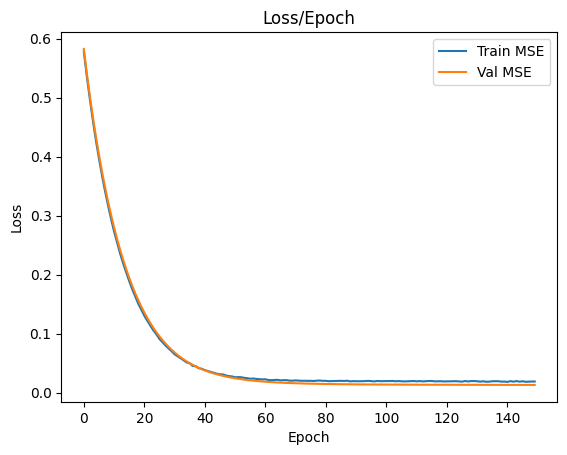

In [170]:
# Plot training and validation losses
sns.lineplot(x=history.epoch, y=history.history['mse'], label='Train MSE')
sns.lineplot(x=history.epoch, y=history.history['val_mse'], label='Val MSE')
plt.title("Loss/Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [159]:
model.evaluate(test_dataset_filt)

4/4 [==============================] - 0s 85ms/step - loss: 0.0085 - mse: 0.0085 - mae: 0.0774


[0.008508579805493355, 0.008508579805493355, 0.0773695856332779]

In [160]:
aod_filt_pred = model.predict(test_dataset_filt)
aod_filt_pred = aod_filt_pred.reshape(-1,)
aod_filt_pred.shape

4/4 [==============================] - 2s 69ms/step


(416,)

In [161]:
off_ = n_train_samples + n_val_samples + n_test_samples - len(aod_filt_pred)
time_steps_pred = np.array(range(len(aod_filt_pred)))
time_steps_pred = time_steps_pred + off_
time_steps_pred.shape

(416,)

<Axes: >

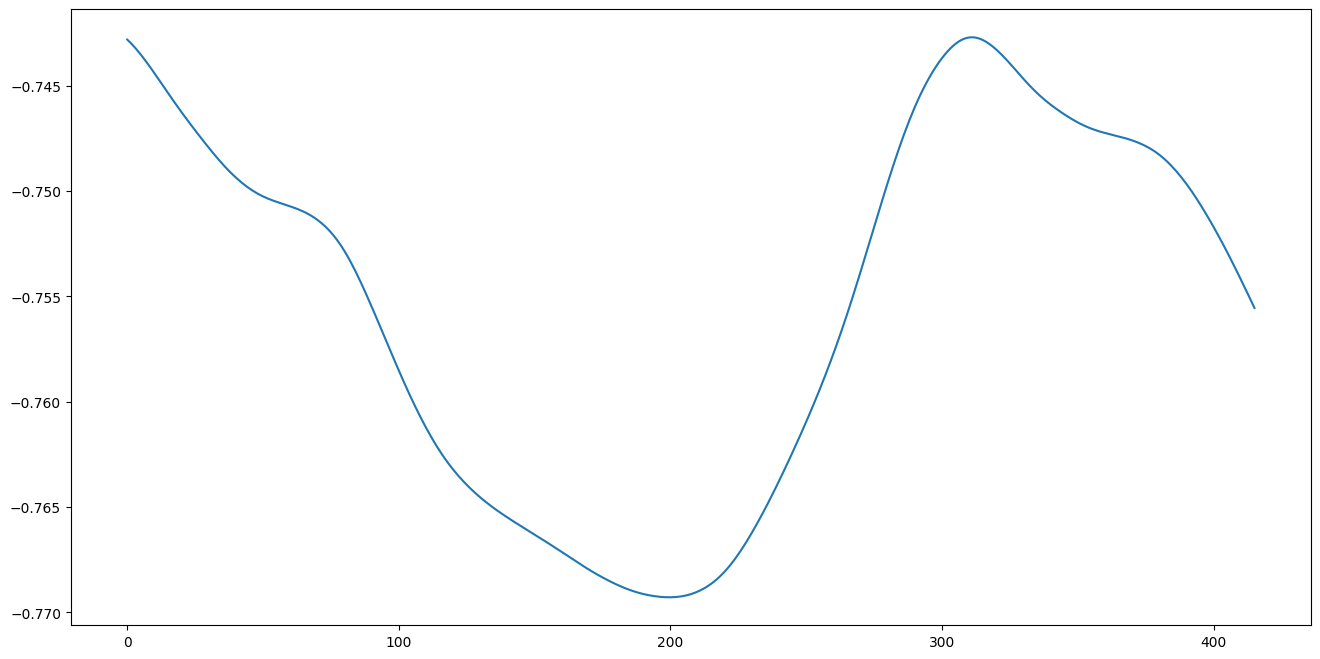

In [162]:
plt.figure(figsize=(16, 8))
sns.lineplot(x=np.array(range(len(aod_filt_pred))), y=aod_filt_pred)

Text(0, 0.5, 'AOD')

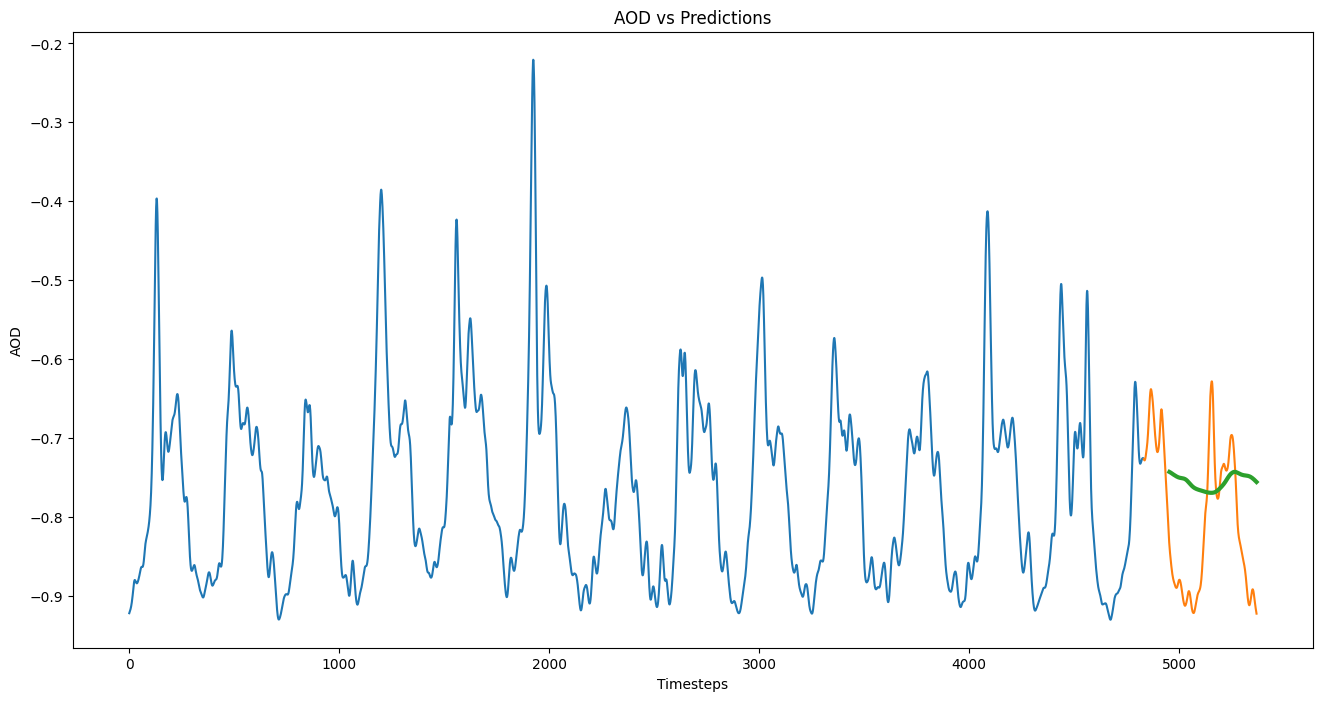

In [171]:
plt.figure(figsize=(16, 8))
sns.lineplot(x=time_steps[:n_train_samples+n_val_samples], y=aod_filt[:n_train_samples+n_val_samples])
sns.lineplot(x=time_steps[n_train_samples+n_val_samples:], y=aod_filt[n_train_samples+n_val_samples:])
sns.lineplot(x=time_steps_pred, y=aod_filt_pred, linewidth=3)
plt.title("AOD vs Predictions")
plt.xlabel("Timesteps")
plt.ylabel("AOD")